In [1]:
import pandas as pd
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
#sqlContext = SQLContext(sc)
from nltk.corpus import stopwords
import re as re
from pyspark.ml.feature import CountVectorizer , IDF
from pyspark.mllib.linalg import Vector, Vectors
#from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.ml.clustering import LDA, LDAModel
import nltk
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.functions import size
from pyspark.sql.functions import udf, col
from pyspark.ml.feature import RegexTokenizer,StopWordsRemover
from pyspark.sql.functions import udf, struct
import pyspark.sql.types as T 
import string
import nltk
from pyspark.sql import Row
from textblob import TextBlob
import os
import sys
from pyspark.sql import SparkSession
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
spark =SparkSession.builder.master("local[1]").appName('SparkProject').getOrCreate() 

22/12/04 11:15:24 WARN Utils: Your hostname, Phaniths-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.0.0.99 instead (on interface en0)
22/12/04 11:15:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/04 11:15:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
tokenizer = RegexTokenizer().setPattern("[\\W_]+").setMinTokenLength(3).setInputCol("content").setOutputCol("tokens")

In [4]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatization(row):
    #row = [stemmer.stem(lemmatizer.lemmatize(word)) for word in row]
    row = [lemmatizer.lemmatize(word,'v') for word in row]
    return row

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/phanithdsv/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
lemmatization = udf(lemmatization)

In [6]:
#tokenizes, remove stopwords, and lammatize data

def preprocess_data(df):
    tokenizer = RegexTokenizer().setPattern("[\\W_]+").setMinTokenLength(3).setInputCol("content").setOutputCol("tokens")
    df = tokenizer.transform(df)
    
    nltk.download('stopwords')
    stopwordList = stopwords.words('english')
    remover = StopWordsRemover(stopWords=stopwordList)
    remover.setInputCol("tokens")
    remover.setOutputCol("filtered")

    df = remover.transform(df)
    
    df=df.withColumn('tokens', lemmatization(df['filtered']))
    return df    

In [7]:
sentiment_polarity = udf(lambda x: TextBlob(x).sentiment[0])
spark.udf.register("sentiment_polarity", sentiment_polarity)

sentiment_subjectivity = udf(lambda x: TextBlob(x).sentiment[1])
spark.udf.register("sentiment_subjectivity", sentiment_subjectivity)

<function __main__.<lambda>(x)>

In [8]:
def get_sentiment(df):
    df = df.withColumn('sentiment_polarity',sentiment_polarity('content').cast('double'))
    df = df.withColumn('sentiment_subjectivity',sentiment_subjectivity('content').cast('double'))
    return df


In [9]:
def get_discrete_sentiment(sentiment_polarity):
    if(sentiment_polarity > 0):
        return 1
    elif(sentiment_polarity < 0):
        return -1
    else:
        return 0 

In [10]:
get_discrete_sentiment = udf(get_discrete_sentiment)

In [11]:
df = spark.read.option("header",True).csv("TopicModellingLabelledTweets.csv")
df = df.drop('_c4','_c5')
df = df.na.drop()
df = df.filter("content != ''")
df.head()

Row(content='less than  days left till the  ecosummit jedlixs cofounder  will speak on may  about integrating evs into the eco system check the program', polarity='0', topic='3', Tweet_No='0')

In [12]:
df = preprocess_data(df)
df = get_sentiment(df)
df = df.withColumn('sentiment',get_discrete_sentiment('sentiment_polarity').cast('double'))
#df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/phanithdsv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
y_true = df.select("polarity").rdd.flatMap(lambda x: x).collect()
y_pred = df.select("sentiment").rdd.flatMap(lambda x: x).collect()

y_true = list(map(int, y_true))
y_pred = list(map(int,y_pred))

In [14]:
f1_score(y_true,y_pred,average='micro')

0.5175879396984925

In [15]:
vis_arr = multilabel_confusion_matrix(y_true, y_pred)

In [16]:
labels = ["Negative Sentiments","Neutral Sentiments","Positive Sentiments"]

In [17]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm,  vmin=20, vmax=800, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)
    

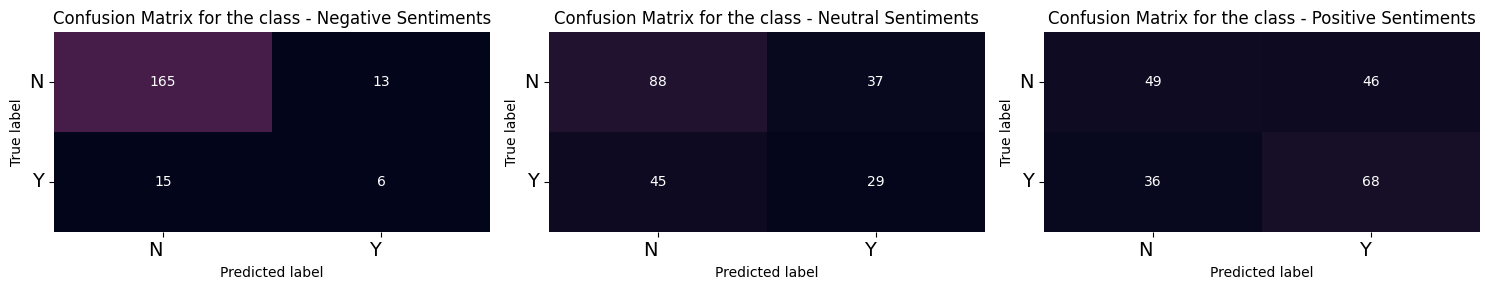

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()